## POS Tagging using Viterbi Algorithm

## In this notebook, I have tried to implement viterbi algorithm and have used it in parts of speech tagging usecase.

In [1]:
#Importing libraries
import nltk
import random
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import seaborn as sns
import pprint, time
from sklearn.model_selection import train_test_split

In [24]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [25]:
print(nltk_data[:4])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [26]:
len(nltk_data)

3914

In [27]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('In', 'ADP'), ('a', 'DET'), ('number', 'NOUN'), ('of', 'ADP'), ('recent', 'ADJ'), ('cases', 'NOUN'), (',', '.'), ('federal', 'ADJ'), ('courts', 'NOUN'), ('have', 'VERB'), ('refused', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('recognize', 'VERB'), ('attorneys', 'NOUN'), ("'", 'PRT'), ('assertions', 'NOUN'), ('that', 'ADP'), ('information', 'NOUN'), ('relating', 'VERB'), ('to', 'PRT'), ('fees', 'NOUN'), ('from', 'ADP'), ('clients', 'NOUN'), ('should', 'VERB'), ('be', 'VERB'), ('confidential', 'ADJ'), ('.', '.')], [('Chrysler', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('its', 'PRON'), ('trucks', 'NOUN'), ('and', 'CONJ'), ('vans', 'NOUN'), ('already', 'ADV'), ('meet', 'VERB'), ('the', 'DET'), ('roof-crush', 'ADJ'), ('resistance', 'NOUN'), ('standard', 'NOUN'), ('for', 'ADP'), ('cars', 'NOUN'), ('.', '.')], [('Critics', 'NOUN'), ('say', 'VERB'), ('0', 'X'), ('South', 'NOUN'), ('Carolina', 'NOUN'), ('is', 'VERB'), ('paying', 'VERB'), ('a', 'DET'), ('price', 'NOUN'), ('by', 'ADP'), ('*

In [28]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95570

In [29]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['In',
 'a',
 'number',
 'of',
 'recent',
 'cases',
 ',',
 'federal',
 'courts',
 'have']

In [30]:
# vocabulary
V = set(tokens)
print(len(V))

12096


In [31]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [32]:
print(T)

{'CONJ', 'VERB', 'ADP', 'ADV', 'PRON', 'NUM', '.', 'PRT', 'DET', 'X', 'NOUN', 'ADJ'}


### Corpus summary:

- Total Number of records: 3914
- Number of records in training set: 3718  (95%)
- Number of records in testing set: 196  (5%)
- Total Number of distinct words in training set = 12091
- Total Number of Tags: 12


### Build the vanilla Viterbi based POS tagger

In [33]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [34]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [35]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [36]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [37]:
tags_matrix

array([[4.63392033e-04, 1.55699715e-01, 5.18999062e-02, 5.51436506e-02,
        5.93141802e-02, 4.03151065e-02, 3.70713621e-02, 4.63392027e-03,
        1.18628360e-01, 8.80444888e-03, 3.49397600e-01, 1.18628360e-01],
       [5.04540885e-03, 1.70146704e-01, 9.09726024e-02, 8.10370222e-02,
        3.46192643e-02, 2.31312588e-02, 3.56283486e-02, 3.09710465e-02,
        1.34207875e-01, 2.19358847e-01, 1.09834664e-01, 6.50469586e-02],
       [8.57173465e-04, 8.35744105e-03, 1.76792033e-02, 1.29647488e-02,
        6.81452900e-02, 6.19307831e-02, 3.97514179e-02, 1.50005356e-03,
        3.25725913e-01, 3.40726450e-02, 3.21440041e-01, 1.07575268e-01],
       [6.67334022e-03, 3.45679015e-01, 1.18118115e-01, 8.07474107e-02,
        1.53486822e-02, 3.13646980e-02, 1.37137130e-01, 1.46813476e-02,
        6.80680647e-02, 2.23556887e-02, 3.10310312e-02, 1.28795460e-01],
       [4.65477118e-03, 4.89138871e-01, 2.28859577e-02, 3.52986827e-02,
        7.37005426e-03, 7.75795197e-03, 3.87897603e-02, 1.20

In [38]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,CONJ,VERB,ADP,ADV,PRON,NUM,.,PRT,DET,X,NOUN,ADJ
CONJ,0.000463,0.155700,0.051900,0.055144,0.059314,0.040315,0.037071,0.004634,0.118628,0.008804,0.349398,0.118628
VERB,0.005045,0.170147,0.090973,0.081037,0.034619,0.023131,0.035628,0.030971,0.134208,0.219359,0.109835,0.065047
ADP,0.000857,0.008357,0.017679,0.012965,0.068145,0.061931,0.039751,0.001500,0.325726,0.034073,0.321440,0.107575
ADV,0.006673,0.345679,0.118118,0.080747,0.015349,0.031365,0.137137,0.014681,0.068068,0.022356,0.031031,0.128795
PRON,0.004655,0.489139,0.022886,0.035299,0.007370,0.007758,0.038790,0.012025,0.009310,0.091932,0.209853,0.070985
NUM,0.013695,0.017267,0.035427,0.002977,0.001489,0.187258,0.116999,0.025007,0.003275,0.213754,0.348616,0.034236
.,0.058049,0.088417,0.090298,0.052316,0.065484,0.081161,0.094150,0.002150,0.173340,0.027860,0.222342,0.044343
PRT,0.002293,0.402555,0.020635,0.010481,0.018015,0.055355,0.043236,0.001638,0.100229,0.014085,0.247953,0.083524
DET,0.000484,0.038936,0.009069,0.012576,0.003628,0.022007,0.017775,0.000242,0.005441,0.045103,0.640629,0.204111
X,0.010486,0.202415,0.145218,0.025580,0.055767,0.002701,0.163171,0.185256,0.054020,0.074992,0.063394,0.017000


In [39]:
tags_df.loc['.', :]

CONJ    0.058049
VERB    0.088417
ADP     0.090298
ADV     0.052316
PRON    0.065484
NUM     0.081161
.       0.094150
PRT     0.002150
DET     0.173340
X       0.027860
NOUN    0.222342
ADJ     0.044343
Name: ., dtype: float32

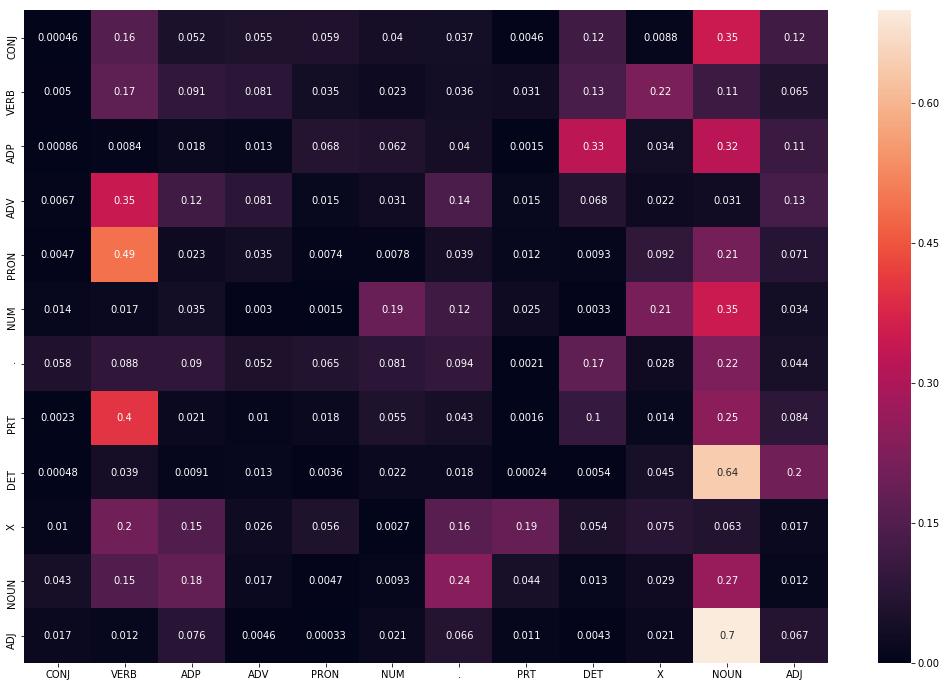

In [41]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df, annot=True)
plt.show()


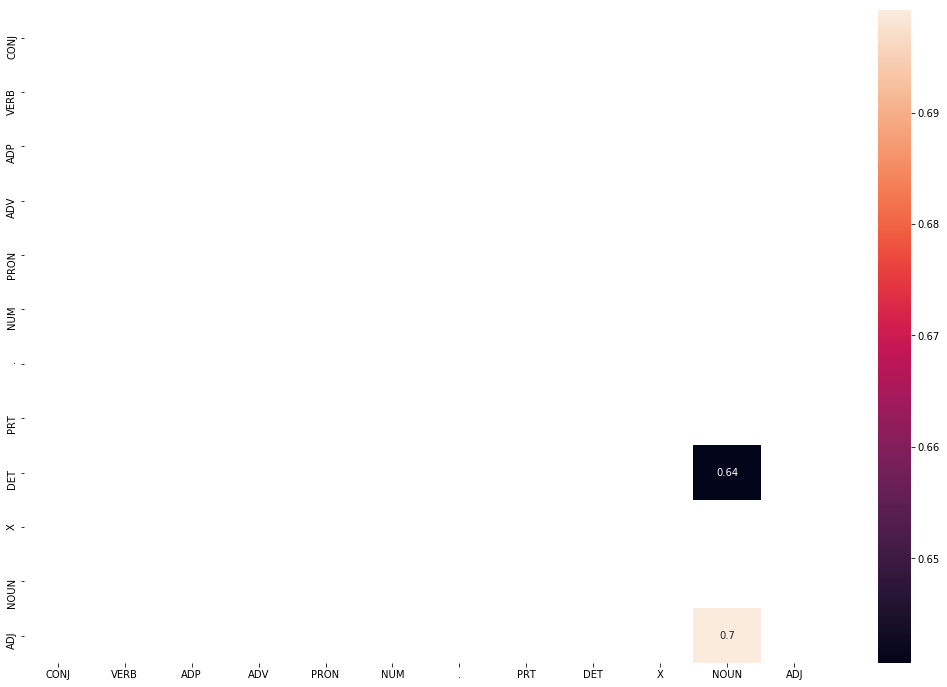

In [42]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent, annot=True)
plt.show()

In [43]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



### Running on entire test dataset would take more than 3-4hrs. 

### Let's test our Viterbi algorithm on a few sample sentences of test dataset. 

### We will use the same test samples to evaluate all versions of Viterbi algo to make comparision easy


In [44]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 50 sents
rndom = [random.randint(1,len(test_set)) for x in range(50)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
#test_run

In [45]:
# tagging the test sentences
start = time.time()
tagged_seq_1 = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [46]:
print("Time taken in seconds: ", difference)
print(tagged_seq_1)

Time taken in seconds:  210.92014002799988
[('But', 'CONJ'), ('civilization', 'CONJ'), ('has', 'VERB'), ('moved', 'VERB'), ('forward', 'ADV'), ('since', 'ADP'), ('then', 'ADV'), ('.', '.'), ('President', 'NOUN'), ('Reagan', 'NOUN'), ('learned', 'VERB'), ('that', 'ADP'), ('lesson', 'NOUN'), ('.', '.'), ('Douglas', 'NOUN'), ('Madison', 'NOUN'), (',', '.'), ('a', 'DET'), ('corporate', 'ADJ'), ('trader', 'NOUN'), ('with', 'ADP'), ('Bank', 'NOUN'), ('of', 'ADP'), ('America', 'NOUN'), ('in', 'ADP'), ('Los', 'NOUN'), ('Angeles', 'NOUN'), (',', '.'), ('traced', 'CONJ'), ('the', 'DET'), ('dollar', 'NOUN'), ("'s", 'PRT'), ('recent', 'ADJ'), ('solid', 'ADJ'), ('performance', 'NOUN'), ('against', 'ADP'), ('the', 'DET'), ('yen', 'NOUN'), ('to', 'PRT'), ('purchases', 'NOUN'), ('of', 'ADP'), ('securities', 'NOUN'), ('by', 'ADP'), ('Japanese', 'ADJ'), ('insurance', 'NOUN'), ('companies', 'NOUN'), ('and', 'CONJ'), ('trust', 'NOUN'), ('banks', 'NOUN'), ('and', 'CONJ'), ('the', 'DET'), ('sense', 'NOUN'),

In [47]:
# accuracy
check_1 = [i for i, j in zip(tagged_seq_1, test_run_base) if i == j] 

In [49]:
accuracy_1 = len(check_1)/len(tagged_seq_1)

In [50]:
accuracy_1

0.9234527687296417

In [51]:
incorrect_tagged_cases_1 = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_1, test_run_base)) if j[0]!=j[1]]

In [52]:
incorrect_tagged_cases_1

[[('But', 'CONJ'), (('civilization', 'CONJ'), ('civilization', 'NOUN'))],
 [('learned', 'VERB'), (('that', 'ADP'), ('that', 'DET'))],
 [(',', '.'), (('traced', 'CONJ'), ('traced', 'VERB'))],
 [('another', 'DET'), (('wave', 'CONJ'), ('wave', 'NOUN'))],
 [('the', 'DET'), (('chief', 'NOUN'), ('chief', 'ADJ'))],
 [('be', 'VERB'), (('as', 'ADP'), ('as', 'ADV'))],
 [('any', 'DET'), (('proposals', 'CONJ'), ('proposals', 'NOUN'))],
 [('.', '.'), (('Areas', 'CONJ'), ('Areas', 'NOUN'))],
 [('particularly', 'ADV'), (('dusty', 'CONJ'), ('dusty', 'ADJ'))],
 [('by', 'ADP'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [("''", '.'), (('evolve', 'CONJ'), ('evolve', 'VERB'))],
 [('evil', 'ADJ'), (('creature', 'CONJ'), ('creature', 'NOUN'))],
 [('is', 'VERB'), (('evoking', 'CONJ'), ('evoking', 'VERB'))],
 [('the', 'DET'), (('curses', 'CONJ'), ('curses', 'NOUN'))],
 [('$', '.'), (('374.20', 'CONJ'), ('374.20', 'NUM'))],
 [(',', '.'), (('down', 'ADV'), ('down', 'ADP'))],
 [('$', '.'), (('374.20', 'CONJ'

### Solve the problem of unknown words

## Viterbi Modification Technique 1: Assign a class/Tag to unknown words based on some rule.

1. We can incorporate simple rule of tagging Unknown words with the Most frequent occuring POS Tag in the corpus.

In [53]:
# Find most frequent Tag
from collections import Counter

tags = [pair[1] for pair in train_tagged_words]
tag_counts = Counter(tags)
tag_counts.most_common(1)[0][0]

'NOUN'

In [54]:
# Viterbi Heuristic
def Viterbi_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    vocab = list(set([pair[0] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        if word not in vocab:
            state.append(tag_counts.most_common(1)[0][0])
            continue
        for tag in T:
            if key == 0:
                transition_p = (tags_df.loc['.', tag])
            else:
                transition_p = (tags_df.loc[state[-1], tag])
                
            # compute emission and state probabilities
            ## perform laplace smoothening on emission probabilities
            
            emission_p = (word_given_tag(words[key], tag)[0])/(word_given_tag(words[key], tag)[1]) 
            #state_probability = transition_p if emission_p==0.0 else emission_p * transition_p
            state_probability = transition_p * emission_p
            #print(transition_p, emission_p, state_probability)
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))


In [55]:
# tagging the test sentences
start = time.time()
tagged_seq_2 = Viterbi_2(test_tagged_words)
end = time.time()
difference = end-start

In [56]:
print("Time taken in seconds: ", difference)
#print(tagged_seq)

Time taken in seconds:  199.08050298690796


In [57]:
# accuracy
check_2 = [i for i, j in zip(tagged_seq_2, test_run_base) if i == j] 
accuracy_2 = len(check_2)/len(tagged_seq_2)
accuracy_2

0.9478827361563518

In [58]:
incorrect_tagged_cases_2 = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_2, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases_2

[[('learned', 'VERB'), (('that', 'ADP'), ('that', 'DET'))],
 [(',', '.'), (('traced', 'NOUN'), ('traced', 'VERB'))],
 [('the', 'DET'), (('chief', 'NOUN'), ('chief', 'ADJ'))],
 [('be', 'VERB'), (('as', 'ADP'), ('as', 'ADV'))],
 [('particularly', 'ADV'), (('dusty', 'NOUN'), ('dusty', 'ADJ'))],
 [('by', 'ADP'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [("''", '.'), (('evolve', 'NOUN'), ('evolve', 'VERB'))],
 [('creature', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('is', 'VERB'), (('evoking', 'NOUN'), ('evoking', 'VERB'))],
 [('$', '.'), (('374.20', 'NOUN'), ('374.20', 'NUM'))],
 [(',', '.'), (('down', 'ADV'), ('down', 'ADP'))],
 [('$', '.'), (('374.20', 'NOUN'), ('374.20', 'NUM'))],
 [(',', '.'), (('down', 'ADV'), ('down', 'ADP'))],
 [('turned', 'VERB'), (('down', 'ADV'), ('down', 'PRT'))],
 [('not', 'ADV'), (('behaving', 'NOUN'), ('behaving', 'VERB'))],
 [('the', 'DET'),
  (('Philadelphia-based', 'NOUN'), ('Philadelphia-based', 'ADJ'))],
 [('to', 'PRT'), (('combine', 'NOUN'),

## Viterbi Modification 2. 

#### Modify Viterbi algo to Consider only either transition or emission probabilities for unknown words.

#### For avoiding 0 probability of unknown words, we can use Laplace smoothening technique.

Transition probability 
\begin{equation*}
P(T2|T1)   = \frac{P(T1,T2) + 1}{len(T)}
\end{equation*}

Emission probability 
\begin{equation*}
P(T|W)   = \frac{P(B,A) + 1}{len(T)}
\end{equation*}

In [59]:
# Viterbi Heuristic
def Viterbi_3(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    vocab = list(set([pair[0] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = (tags_df.loc['.', tag] + 1) / len(T)
            else:
                transition_p = (tags_df.loc[state[-1], tag] + 1) / len(T)
                
            # compute emission and state probabilities
            ## perform laplace smoothening on emission probabilities
            
            emission_p = (word_given_tag(words[key], tag)[0] + 1)/(word_given_tag(words[key], tag)[1] + len(vocab)) 
            #state_probability = transition_p if emission_p==0.0 else emission_p * transition_p
            state_probability = transition_p * emission_p
            #print(transition_p, emission_p, state_probability)
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))


In [60]:
# tagging the test sentences
start = time.time()
tagged_seq_3 = Viterbi_3(test_tagged_words)
end = time.time()
difference = end-start

In [61]:
print("Time taken in seconds: ", difference)
#print(tagged_seq)

Time taken in seconds:  237.42239809036255


In [62]:
# accuracy
check_3 = [i for i, j in zip(tagged_seq_3, test_run_base) if i == j] 
accuracy_3 = len(check_3)/len(tagged_seq_3)
accuracy_3

0.9071661237785016

In [63]:
incorrect_tagged_cases_3 = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_3, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases_3

[[('But', 'CONJ'), (('civilization', 'PRON'), ('civilization', 'NOUN'))],
 [('learned', 'VERB'), (('that', 'ADP'), ('that', 'DET'))],
 [(',', '.'), (('traced', 'CONJ'), ('traced', 'VERB'))],
 [('another', 'DET'), (('wave', 'CONJ'), ('wave', 'NOUN'))],
 [('the', 'DET'), (('chief', 'NOUN'), ('chief', 'ADJ'))],
 [('I', 'PRON'), (('like', 'ADP'), ('like', 'VERB'))],
 [('be', 'VERB'), (('as', 'ADP'), ('as', 'ADV'))],
 [('any', 'DET'), (('proposals', 'CONJ'), ('proposals', 'NOUN'))],
 [('.', '.'), (('Areas', 'CONJ'), ('Areas', 'NOUN'))],
 [('particularly', 'ADV'), (('dusty', 'ADV'), ('dusty', 'ADJ'))],
 [('with', 'ADP'),
  (('limited-partnership', 'PRON'), ('limited-partnership', 'NOUN'))],
 [('by', 'ADP'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [("''", '.'), (('evolve', 'CONJ'), ('evolve', 'VERB'))],
 [('evil', 'ADJ'), (('creature', 'CONJ'), ('creature', 'NOUN'))],
 [('creature', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('is', 'VERB'), (('evoking', 'ADV'), ('evoking', 'VERB')

### Lets combine both the approaches and see the combined results:

In [64]:
# Find most frequent Tag
from collections import Counter

tags = [pair[1] for pair in train_tagged_words]
tag_counts = Counter(tags)
tag_counts.most_common(1)[0][0]

'NOUN'

In [65]:
# Viterbi Heuristic
def Viterbi_4(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    vocab = list(set([pair[0] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        if word not in vocab:
            state.append(tag_counts.most_common(1)[0][0])
            continue
        for tag in T:
            if key == 0:
                transition_p = (tags_df.loc['.', tag] + 1) / len(T)
            else:
                transition_p = (tags_df.loc[state[-1], tag] + 1) / len(T)
                
            # compute emission and state probabilities
            ## perform laplace smoothening on emission probabilities
            
            emission_p = (word_given_tag(words[key], tag)[0] + 1)/(word_given_tag(words[key], tag)[1] + len(vocab)) 
            #state_probability = transition_p if emission_p==0.0 else emission_p * transition_p
            state_probability = transition_p * emission_p
            #print(transition_p, emission_p, state_probability)
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words, state))


In [66]:
# tagging the test sentences
start = time.time()
tagged_seq_4 = Viterbi_4(test_tagged_words)
end = time.time()
difference = end-start

In [67]:
print("Time taken in seconds: ", difference)
#print(tagged_seq)

Time taken in seconds:  218.10019516944885


In [68]:
# accuracy
check_4 = [i for i, j in zip(tagged_seq_4, test_run_base) if i == j] 
accuracy_4 = len(check_4)/len(tagged_seq_4)
accuracy_4

0.9332247557003257

In [69]:
incorrect_tagged_cases_4 = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_4, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases_4

[[('learned', 'VERB'), (('that', 'ADP'), ('that', 'DET'))],
 [(',', '.'), (('traced', 'NOUN'), ('traced', 'VERB'))],
 [('the', 'DET'), (('chief', 'NOUN'), ('chief', 'ADJ'))],
 [('I', 'PRON'), (('like', 'ADP'), ('like', 'VERB'))],
 [('be', 'VERB'), (('as', 'ADP'), ('as', 'ADV'))],
 [('particularly', 'ADV'), (('dusty', 'NOUN'), ('dusty', 'ADJ'))],
 [('with', 'ADP'),
  (('limited-partnership', 'PRON'), ('limited-partnership', 'NOUN'))],
 [('by', 'ADP'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [("''", '.'), (('evolve', 'NOUN'), ('evolve', 'VERB'))],
 [('creature', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('is', 'VERB'), (('evoking', 'NOUN'), ('evoking', 'VERB'))],
 [('$', '.'), (('374.20', 'NOUN'), ('374.20', 'NUM'))],
 [(',', '.'), (('down', 'ADV'), ('down', 'ADP'))],
 [('held', 'VERB'), (('A.L.', 'ADV'), ('A.L.', 'NOUN'))],
 [('$', '.'), (('374.20', 'NOUN'), ('374.20', 'NUM'))],
 [(',', '.'), (('down', 'ADV'), ('down', 'ADP'))],
 [('turned', 'VERB'), (('down', 'ADV'), ('dow

## Let's compare results of all modifications in terms of accuracy

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [92]:
## Lets check the incorrectly Tagged words by Vanilla viterbi model
incorrect_tagged_cases_1[0]

[('But', 'CONJ'), (('civilization', 'CONJ'), ('civilization', 'NOUN'))]

In [93]:
## The same is now tagged correctly with the 4th model.
## Les's check them in the correctly tagged sentences of model 4
check_4[:5]

[('But', 'CONJ'),
 ('civilization', 'NOUN'),
 ('has', 'VERB'),
 ('moved', 'VERB'),
 ('forward', 'ADV')]

### Let's now run our final model with the sample data provided


In [99]:
from nltk.tokenize import word_tokenize

fname = "Test_sentences.txt"

with open(fname) as f:
    content = f.readlines()
    for sent in content:
        words = word_tokenize(sent)
        tagged_seq = Viterbi_4(words)
        print(tagged_seq)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'PRON'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.')]
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]
[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DE